In [1]:
using DifferentialEquations; using LinearAlgebra; using Plots; gr();
using LaTeXStrings

# Neutrino Propagation through Earth - vacuum case

We want to propagate neutrinos as they travel through Earth with a given density distribution. Since neutrinos oscillate, we need solve the following first order, complex domain, 3 coupled diff. equations: 
$$i\frac{d\vec{\nu}}{dt} =
\frac{1}{2E}
\left[
U
\begin{pmatrix}
   m_1^2 & 0 & 0 \\
   0 & m_2^2 & 0 \\
   0 & 0 & m_3^2 \\ 
\end{pmatrix}
U^{+}
+ 2\sqrt{2}G_{F}N_{e}E
\begin{pmatrix}
   1 & 0 & 0 \\
   0 & 0 & 0 \\
   0 & 0 & 0 \\ 
\end{pmatrix}
\right]
  \vec{\nu}$$
  
On the LHS, $i$ is the complex imaginary unit, $t$ is the time, $\vec{\nu} = \{\nu_e, \nu_\mu, \nu_\tau\} $ is the vector of 3 flavor states (hence 3 equations) which can oscillate to each other. On the RHS, $U$ is the Pontecorvo–Maki–Nakagawa–Sakata (PMNS) matrix, $N_{e}$ is the (local) electron number density in matter, and $G_{F}$ is the Fermi constant. The survival probability, used to parameterize the reduction in the measured flux, is calculated as $P(\nu^i \rightarrow \nu^i) = |\langle \nu^i (t)|\nu^i (0)\rangle|^{2}$. For an arbitrary, varying density profile (which is the aim of the current project), there is no general analytical solution to this differential equation. Therefore, it is solved numerically by emitting a neutrino from a given point inside Earth isotropically and using a stepping algorithm to evolve the equation until the neutrino has reached the surface. In this example, it is only solved for a 1D case.

First define constants and units that we will need.

In [3]:
######################
# Bunch of constants #
######################

# Pi
PIGREEK = 3.141592654;
# hbarc
hbarc = 197.327; # MeV * fm 

# Earth
EarthRadius = 6371.0; #km
EarthDiameter = 2*EarthRadius;

# Compute factor = 2.*sqrt(2) * G_F * Y_e * density * E /m_p
# G_F = 8.92 e-8 GeV fm^3 
# Y_e= 0.5 (this is an assumption!) 
# m_n = 1.672 e-24 g 
# density is given in g/cm^3 
# energy is given in GeV
# distance in Km, mass in grams
# to get right dimensions we compute parammsw = factor/(2 * hbarc * E)
Parammsw=1.9207e-4;

# double Angles (from Koike and Sato!)
t12=33.0/180.0*PIGREEK;
t13=asin(sqrt(0.025));
t23 = PIGREEK/4.0;
delta=-90.0 / 180.0*PIGREEK;

# Differences in mass squared
dm32=2.32e-3;
dm21=7.59e-5;

# Neutrino energy
Enu = 0.03; # GeV

We fill up now the PMNS mixing matrix, which is a complex values matrix, and parametrized with 3 angles, 1 complex phase and 3 mass squares. The best measured values are given by the PDG.

In [4]:
# Fill PMNS Mixing matrix, U

# initialize to 0 (note it is implicitely complex type for all elements!)
U = [0.0+im*0.0 0.0+im*0.0 0.0+im*0.0; 0 0 0 ; 0 0 0 ]

# 3 angles (t12, t13, t23), and the complex phase (delta)
c13 = cos(t13);
s13 = sin(t13);
  
c12 = cos(t12);
s12 = sin(t12);
  
c23 = cos(t23);
s23 = sin(t23);

# e1, e2, e3
U[1,1] = c12*c13 + im*0.0     
U[1,2] = s12*c13 + im*0.0    
U[1,3] = s13*cos(delta)- im*s13*sin(delta)  

# mu1, mu2, mu3
U[2,1] = -s12*c23-(c12*s23*s13*cos(delta)) + im*(-c12*s23*s13*sin(delta))
U[2,2] = c12*c23-(s12*s23*s13*cos(delta)) + im*(-s12*s23*s13*sin(delta))
U[2,3] = s23*c13 + im*0.0

#tau1, tau2, tau3
U[3,1] = s12*s23-(c12*c23*s13*cos(delta)) + im*(-c12*c23*s13*sin(delta))
U[3,2] = -c12*s23-(s12*c23*s13*cos(delta)) + im*(-s12*c23*s13*sin(delta))
U[3,3] = c23*c13 + im*0.0

#display(U)

# Filling mass squared differences
Mass = [0.0; 0.0; 0.0]
Mass2 = Mass
Mass[1]=0.0;
Mass[2]=sqrt(Mass[1]*Mass[1]+dm21);
Mass[3]=sqrt(Mass[2]*Mass[2]+dm32);
dm31=Mass[3]*Mass[3]-Mass[1]*Mass[1];
Mass2[1] = Mass[1]*Mass[1]
Mass2[2] = Mass[2]*Mass[2]
Mass2[3] = Mass[3]*Mass[3]
Mmass = [0.0+im*0.0 0.0+im*0.0 0.0+im*0.0; 0 0 0 ; 0 0 0 ]
Mmass[1,1] = Mass2[1] + im*0.0;
Mmass[2,2] = Mass2[2] + im*0.0;
Mmass[3,3] = Mass2[3] + im*0.0;

#display(Mmass)



## Propagation in vaccum.

The RHS of the equation (which we call the Hamiltonian) we need to calculate here. As a first step we only consider vacuum, such that the second term in the sum of the Hamiltonian (depending on the density) is zero.
$$i\frac{d\vec{\nu}}{dt} =
\frac{1}{2E}
\left[
U
\begin{pmatrix}
   m_1^2 & 0 & 0 \\
   0 & m_2^2 & 0 \\
   0 & 0 & m_3^2 \\ 
\end{pmatrix}
U^{+}
\right]
  \vec{\nu}$$

In [5]:
# Hamiltonian - first for vacuum only

Udagger = transpose(U)
Udagger = broadcast(conj, Udagger)
#display(Udagger)
H1 = Mmass*Udagger
#display(U)
#display(H1)
H = U*H1
#display(H)
#Base.print_matrix(stdout, H)

p=1.0/(2.0*hbarc*1.0e6*1.0e-18)/Enu/1.0e9 + im*0;
Scale = UniformScaling(p)
Hmat = Scale*H;
#Hmat[1,1]
#Base.print_matrix(stdout, Hmat)

In [6]:
# The derivatives, for propagating in vacuum
function Eq(du, u, p, t)
    du[1] = Hmat[1,1]*u[1]+ Hmat[1,2]*u[2]+Hmat[1,3]*u[3]
    du[2] = Hmat[2,1]*u[1]+ Hmat[2,2]*u[2]+Hmat[2,3]*u[3]
    du[3] = Hmat[3,1]*u[1]+ Hmat[3,2]*u[2]+Hmat[3,3]*u[3]

    # multiply by -i
    du[1] = du[1]*(0+1.0*im)
    du[2] = du[2]*(0+1.0*im)
    du[3] = du[3]*(0+1.0*im)
end

Eq (generic function with 1 method)

We need to define the ODE problem, by specifying the initial value of the 3 states at time zero, the equations and the time span, which for now we just quantify in terms of the Earth radius. 

In [7]:
# Initial value, in flavour basis, start with nue
u0 = [1.0+im*0.0,0.0+im*0.0,0.0+im*0.0]
tspan = (0.0, EarthRadius)
prob = ODEProblem(Eq,u0,tspan)



ODEProblem with uType Array{Complex{Float64},1} and tType Float64. In-place: true
timespan: (0.0, 6371.0)
u0: Complex{Float64}[1.0+0.0im, 0.0+0.0im, 0.0+0.0im]

Then ask Julia to solve it. There are a number of methods to solve, one could also try "Tsit5()", or others. One can also specify the relative tolerance, e.g. "reltol=1e-9".

In [8]:
sol = solve(prob, BS3(), adaptive=false, dt=0.5)

retcode: Success
Interpolation: 3rd order Hermite
t: 12743-element Array{Float64,1}:
    0.0
    0.5
    1.0
    1.5
    2.0
    2.5
    3.0
    3.5
    4.0
    4.5
    5.0
    5.5
    6.0
    ⋮  
 6365.5
 6366.0
 6366.5
 6367.0
 6367.5
 6368.0
 6368.5
 6369.0
 6369.5
 6370.0
 6370.5
 6371.0
u: 12743-element Array{Array{Complex{Float64},1},1}:
 [1.0+0.0im, 0.0+0.0im, 0.0+0.0im]                                       
 [0.999871+0.00345225im, 0.0110445+0.0015872im, 0.0110477-0.000457322im] 
 [0.999484+0.00687865im, 0.0219715+0.00429751im, 0.0219846+0.000208494im]
 [0.998843+0.0102536im, 0.0326682+0.00811364im, 0.0326977+0.00198018im]  
 [0.997956+0.0135521im, 0.043024+0.013007im, 0.0430764+0.00482914im]     
 [0.996831+0.0167498im, 0.0529318+0.0189379im, 0.0530137+0.00871577im]   
 [0.995479+0.0198235im, 0.062289+0.0258562im, 0.0624069+0.0135898im]     
 [0.993914+0.0227513im, 0.0709986+0.0337015im, 0.0711592+0.019391im]     
 [0.992152+0.0255126im, 0.0789703+0.0424039im, 0.07918+0.02604

To get the probability we needed to calcule the absolute value of the state function $P(\nu_i \rightarrow \nu_i) = |\langle \nu_e (t)|\nu_e (0)\rangle|^{2}$, in this particular case we want to evalute $|\langle \nu_e (t)|\nu_e (0)\rangle|^{2}$, that is the survival probability of starting out as the $\nu_e$ state in the first column and ending up also in the $\nu_e$ state of the first column type. Since we are in the flavor basis, and we started at the initial value of the state vector as a pure $\nu_e$ basis state, $\vec{\nu}(t = 0) = \{1.0, 0.0, 0.0\}$ we just need to calculate the magnitude squared of the function. In Julia it is a bit tedious. We first need to take out the first column and then take the absolute value of the complex numbers for each time step.

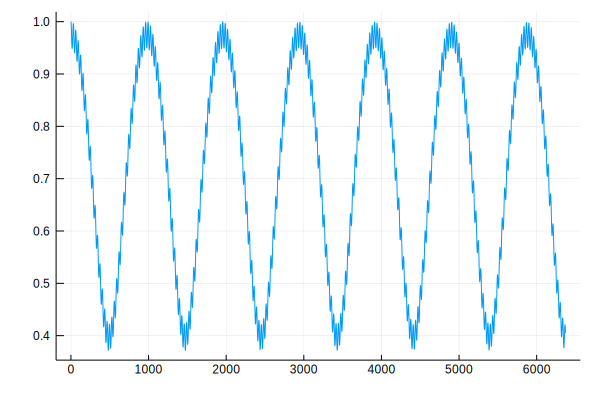

sh: 1: dvipng: not found
dvipng: PNG conversion failed
sh: 1: dvipng: not found
dvipng: PNG conversion failed


In [10]:
# plot the result
A = sol.u
B = hcat(A...)'

ValuesU1 = B[1:length(B[:,1]), 1]
AbsValuesU1 = broadcast(abs, ValuesU1)
Times = sol.t[1:length(B[:,1])]
#plot(Times, ValuesU1)
plot(Times, AbsValuesU1, legend=false, xlabel = L"\mathrm{Distance [km]}", ylabel = L"\mathrm{Probability} (\nu_{e}\rightarrow\nu_{e}) ")